# Pre-requisites

1. Install [`python-ace`](https://github.com/ICAMS/python-ace) and [`tensorpotential`](https://github.com/ICAMS/TensorPotential), check more instructions [here](https://pacemaker.readthedocs.io/en/latest/pacemaker/install/) into pyiron conda environment

2. Add following files into `~/pyiron/resources/pacemaker/bin`:

**~/pyiron/resources/pacemaker/bin/run_pacemaker_tf.sh**:
```bash
#!/bin/bash

source $HOME/.bashrc
conda activate PYIRON_AND_PACEMAKER_CONDA_ENVIRONMENT
TF_FORCE_GPU_ALLOW_GROWTH=true pacemaker input.yaml -l log.txt
pace_yaml2yace output_potential.yaml
```

**~/pyiron/resources/pacemaker/bin/run_pacemaker_tf_cpu.sh**:
```bash
#!/bin/bash

source $HOME/.bashrc
conda activate PYIRON_AND_PACEMAKER_CONDA_ENVIRONMENT
CUDA_VISIBLE_DEVICES=-1 pacemaker input.yaml -l log.txt
pace_yaml2yace output_potential.yaml

```

or get it from https://github.com/pyiron/pyiron-resources

# Import and load

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from pyiron import Project

In [3]:
pr = Project('fit_pace')

# Loading training containers

In [4]:
training_container_1 = pr['initial/initial']

In [5]:
training_container_2 = pr['initial/offstoichiometry']

# Create PacemakerJob

In [4]:
job = pr.create_job(pr.job_type.PacemakerJob, "pacemaker_job")

In [6]:
job.add_training_data(training_container_1)

In [ ]:
job.add_training_data(training_container_2)

In [7]:
# set cutoff
job.cutoff=7.0

In [8]:
# set number of iterations
job.input["fit"]["maxiter"]=1000

In [9]:
job.input

,Parameter,Value,Comment
0,cutoff,7.0,
1,metadata,{'comment': 'pyiron-generated fitting job'},
2,data,{},
3,potential,"{'elements': [], 'bonds': {'ALL': {'radbase': ...",
4,fit,"{'loss': {'L1_coeffs': 1e-08, 'L2_coeffs': 1e-...",
5,backend,"{'batch_size': 100, 'display_step': 50, 'evalu...",


## Specification of ACE potential

### Embeddings

Embeddings for `ALL` species (i.e. Al and Li): 
- non-linear `FinnisSinclairShiftedScaled`
- 2 densities
- fs_parameters': [1, 1, 1, 0.5]:
$$E_i = 1.0 * \varphi(1)^1 + 1.0 * \varphi(2)^{0.5} = \varphi^{(1)} + \sqrt{\varphi^{(2)}} $$

In [10]:
job.input["potential"]["embeddings"]

{'ALL': {'fs_parameters': [1, 1, 1, 0.5],
  'ndensity': 2,
  'npot': 'FinnisSinclairShiftedScaled'}}

### Radial functions

Radial functions are orthogonal polynoms example:
* (a) Exponentially-scaled Chebyshev polynomials (λ = 5.25)
* (b) Power-law scaled Chebyshev polynomials (λ = 2.0)
* (c) Simplified spherical Bessel functions

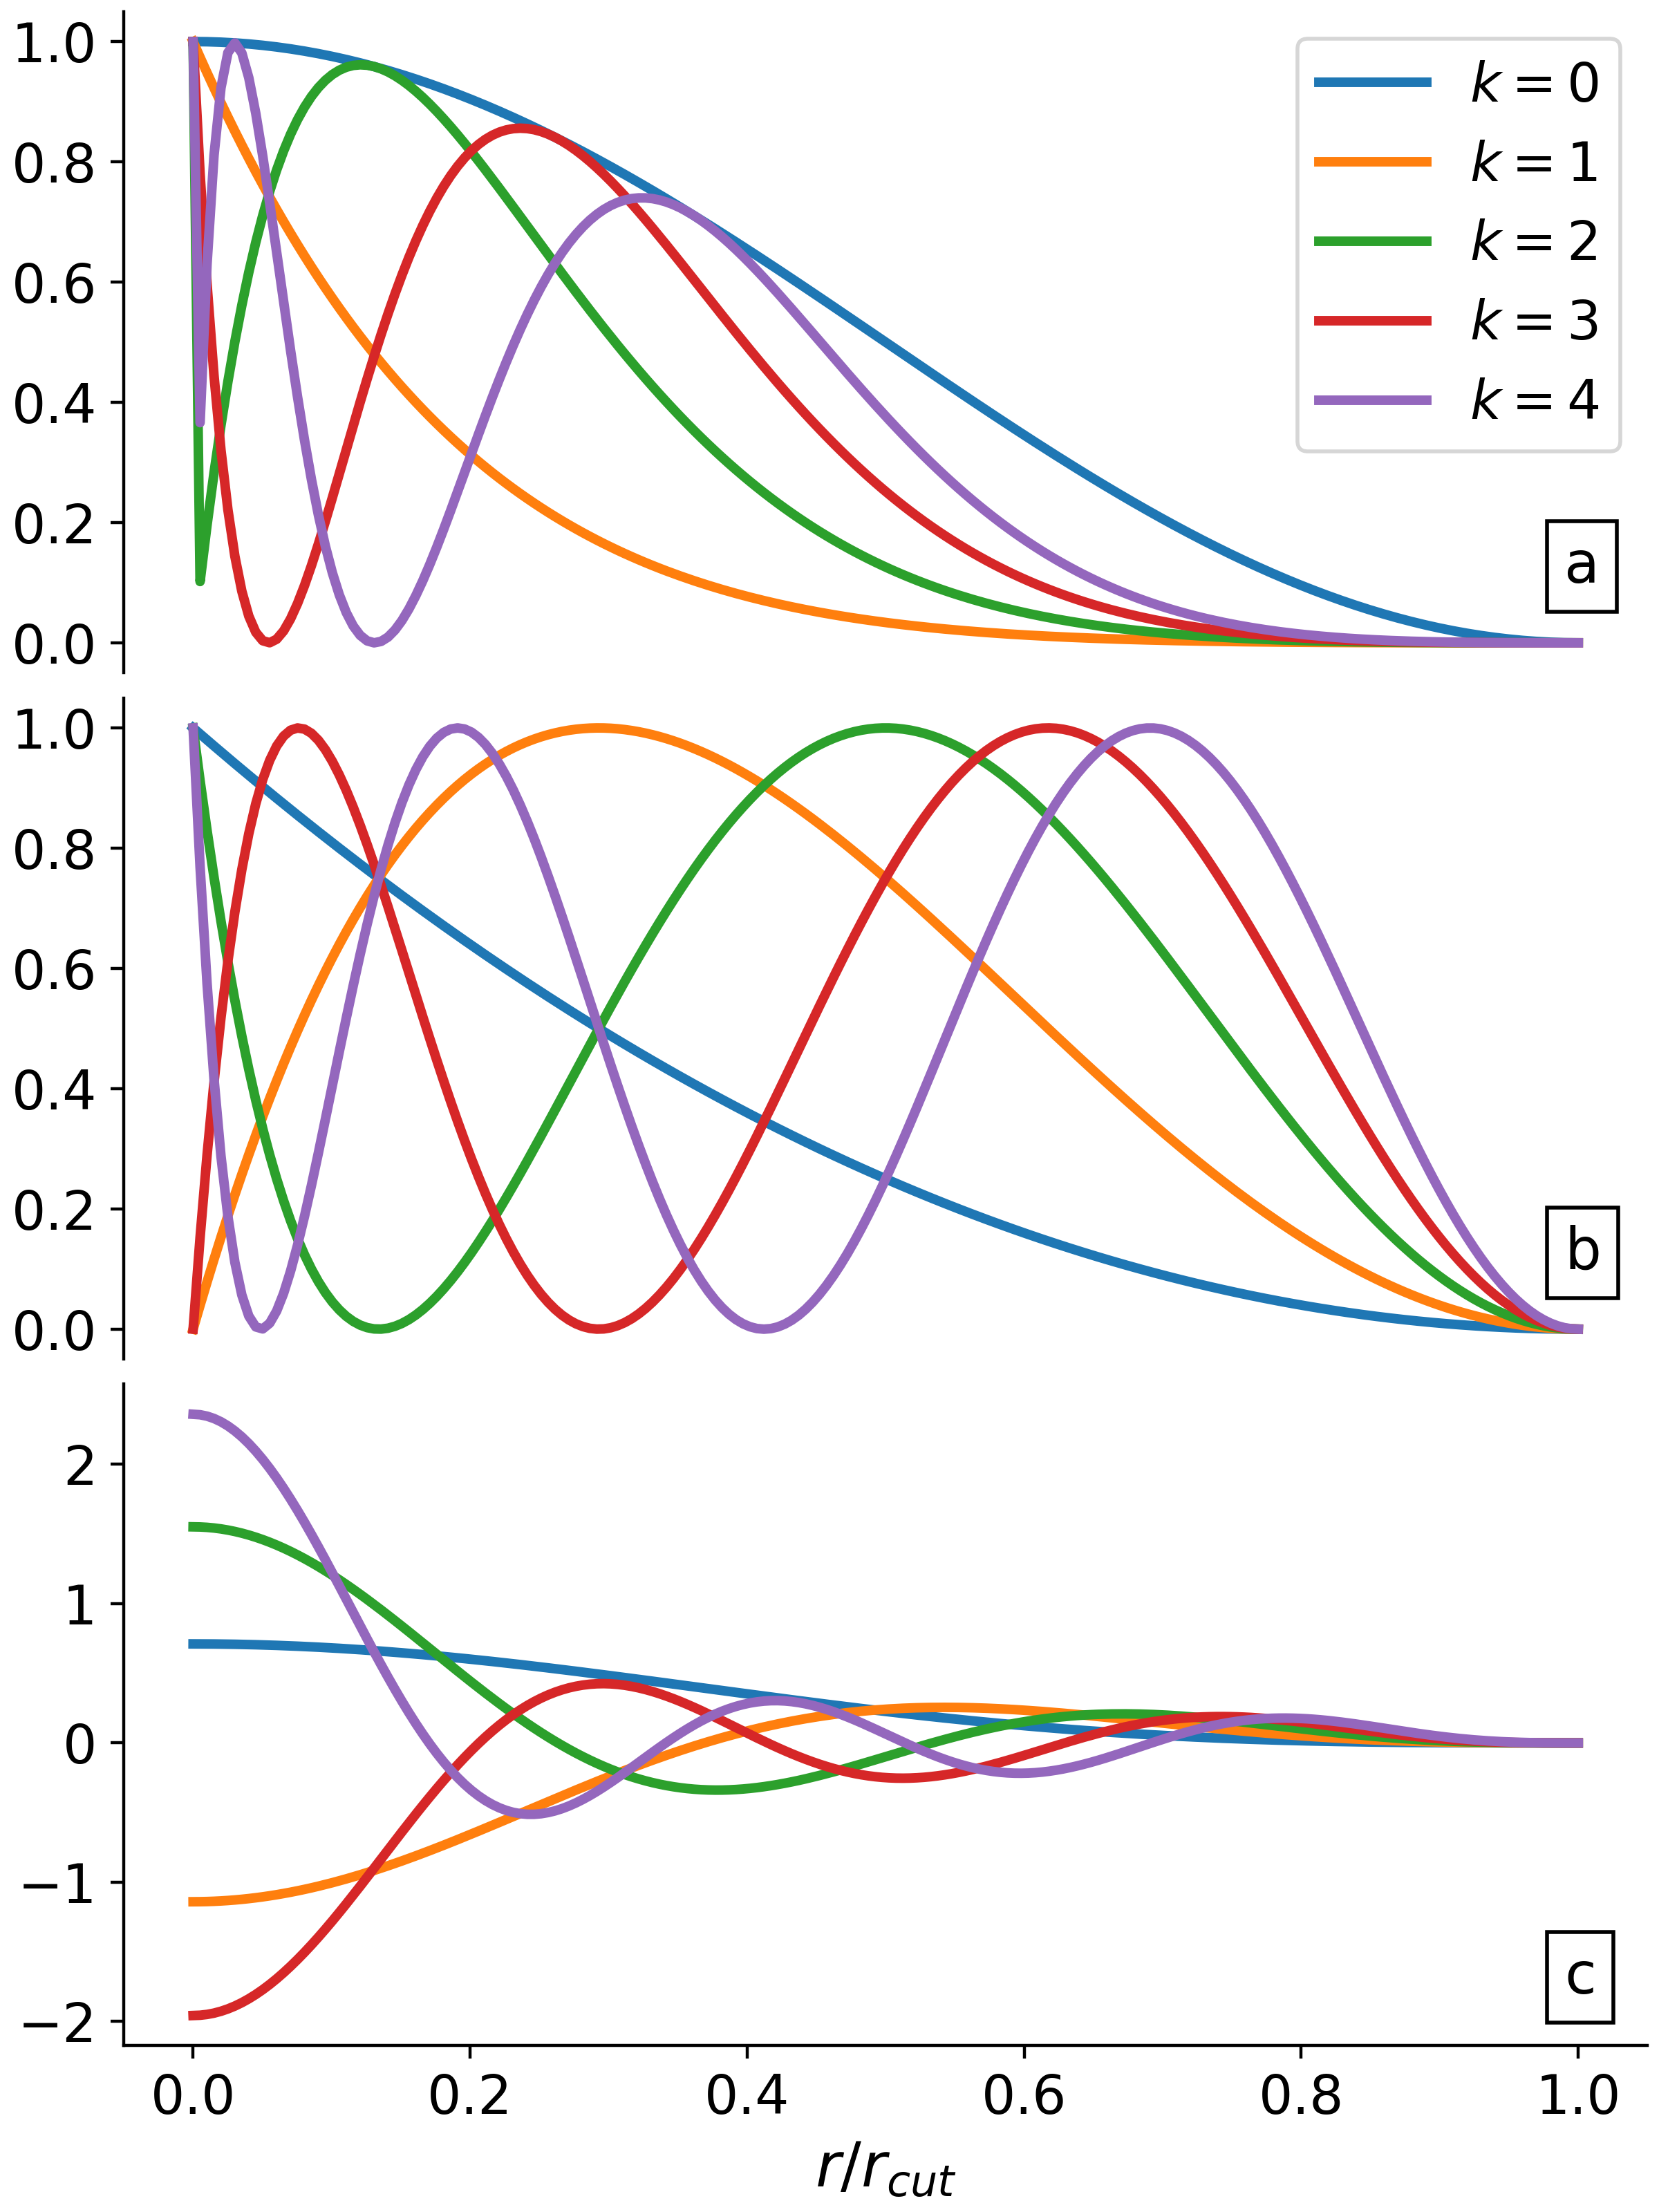

Radial functions specification for `ALL` species pairs (i.e. Al-Al, Al-Li, Li-Al, Li-Li):

* based on the Simplified Bessel
* cutoff $r_c=7.0$

In [11]:
job.input["potential"]["bonds"]

{'ALL': {'radbase': 'SBessel',
  'rcut': 7.0,
  'dcut': 0.01,
  'radparameters': [5.25]}}

### B-basis functions

B-basis functions  for `ALL` species type interactions, i.e. Al-Al, Al-Li, Li-Al, Li-Li blocks:
* maximum order = 4, i.e. body-order 5 (1 central atom + 4 neighbour  densities)
* nradmax_by_orders: 15, 3, 2, 1
* lmax_by_orders: 0, 3, 2, 1

In [12]:
job.input["potential"]["functions"]

{'ALL': {'nradmax_by_orders': [15, 3, 2, 1], 'lmax_by_orders': [0, 3, 2, 1]}}

## Fit/loss specification

Loss function specification

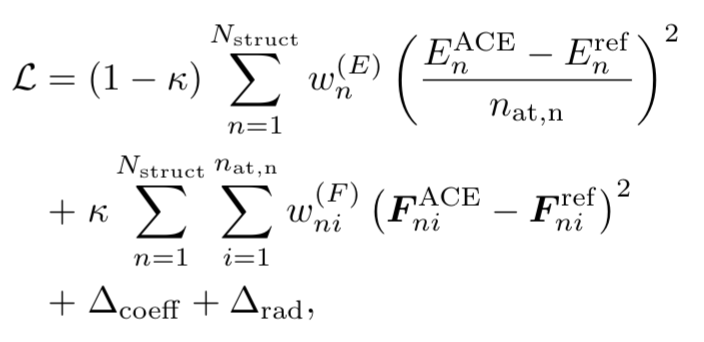

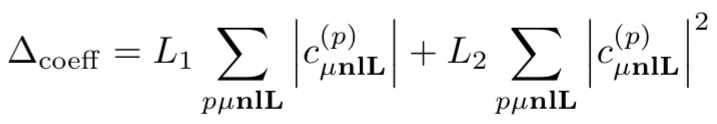

In [13]:
job.input["fit"]['loss']

{'L1_coeffs': 1e-08,
 'L2_coeffs': 1e-08,
 'kappa': 0.3,
 'w0_rad': 0,
 'w1_rad': 0,
 'w2_rad': 0}

### Weighting

In [14]:
job.input["fit"]['weighting'] =  {
        ## weights for the structures energies/forces are associated according to the distance to E_min:
        ## convex hull ( energy: convex_hull) or minimal energy per atom (energy: cohesive)
        "type": "EnergyBasedWeightingPolicy",
        ## number of structures to randomly select from the initial dataset
        "nfit": 10000,         
        ## only the structures with energy up to E_min + DEup will be selected
        "DEup": 10.0,  ## eV, upper energy range (E_min + DElow, E_min + DEup)        
        ## only the structures with maximal force on atom  up to DFup will be selected
        "DFup": 50.0, ## eV/A
        ## lower energy range (E_min, E_min + DElow)
        "DElow": 1.0,  ## eV
        ## delta_E  shift for weights, see paper
        "DE": 1.0,
        ## delta_F  shift for weights, see paper
        "DF": 1.0,
        ## 0<wlow<1 or None: if provided, the renormalization weights of the structures on lower energy range (see DElow)
        "wlow": 0.75,        
        ##  "convex_hull" or "cohesive" : method to compute the E_min
        "energy": "convex_hull",        
        ## structures types: all (default), bulk or cluster
        "reftype": "all",        
        ## random number seed
        "seed": 42 
}

### Minimization and backend specification

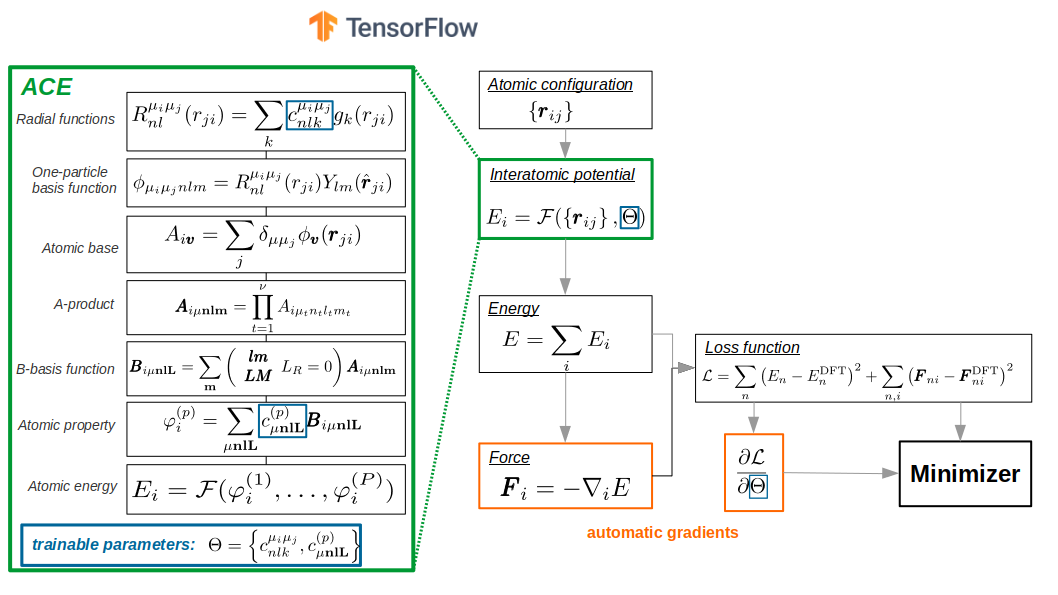

Type of optimizer: `SciPy.minimize.BFGS`

In [21]:
job.input["fit"]["optimizer"]

'BFGS'

Maximum number of iterations by minimizer:

In [22]:
job.input["fit"]["maxiter"]

1000

Batch size:

In [27]:
job.input["backend"]["batch_size"]

100

Backend specification

In [28]:
job.input["backend"]["evaluator"]

'tensorpot'

Check [official documentation](https://pacemaker.readthedocs.io/en/latest/pacemaker/inputfile/) for more details

# Run fit

In [17]:
job.run()

Set automatically determined list of elements: ['Al', 'Li']
The job pacemaker_job was saved and received the ID: 4


In [46]:
job.collect_output()

# Analyse fit

plot loss function

[]

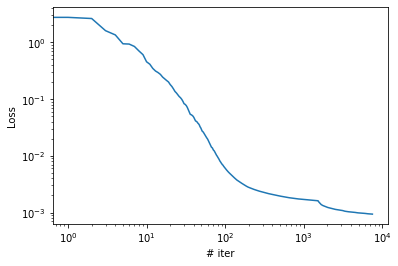

In [48]:
plt.plot(job["output/log/loss"])
plt.xlabel("# iter")
plt.ylabel("Loss")
plt.loglog()

plot energy per atom RMSE

[]

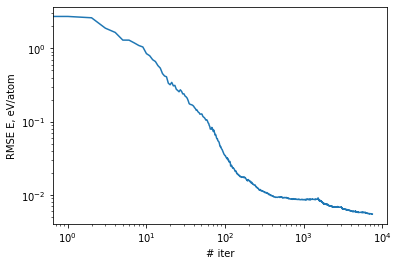

In [50]:
plt.plot(job["output/log/rmse_epa"])
plt.xlabel("# iter")
plt.ylabel("RMSE E, eV/atom")
plt.loglog()

plot force component RMSE

[]

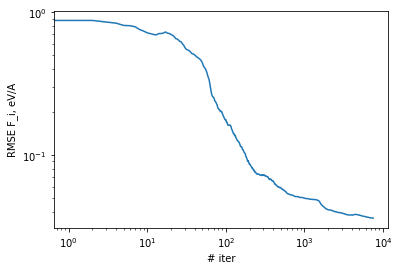

In [51]:
plt.plot(job["output/log/rmse_f_comp"])
plt.xlabel("# iter")
plt.ylabel("RMSE F_i, eV/A")
plt.loglog()

load DataFrame with predictions

In [52]:
pred_df = job.predicted_data

In [53]:
pred_df["energy_pred_per_atom"] = pred_df["energy_pred"]/pred_df["NUMBER_OF_ATOMS"]

Text(0, 0.5, 'ACE E, eV/atom')

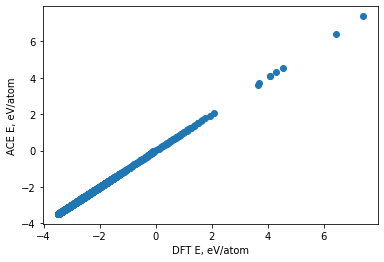

In [54]:
plt.scatter(pred_df["energy_corrected_per_atom"], pred_df["energy_pred_per_atom"])
plt.xlabel("DFT E, eV/atom")
plt.ylabel("ACE E, eV/atom")

Text(0, 0.5, 'ACE F_i, eV/A')

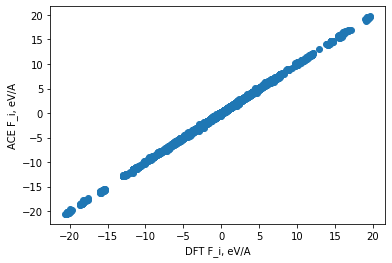

In [55]:
plt.scatter(np.vstack(pred_df["forces"]),  np.vstack(pred_df["forces_pred"]))
plt.xlabel("DFT F_i, eV/A")
plt.ylabel("ACE F_i, eV/A")

Check more in `job.working_directory`/report folder

In [43]:
! ls {job.working_directory}/report

train_E-dE-dist.png  train_EF-pairplots.png  train_Fi-dFi-dist.png
train_E-dE-nn.png    train_F-dF-dist.png


# How actual potential file looks like ?

`output_potential.yaml`:

```yaml
species:
    # Pure Al interaction block
  - speciesblock: Al
    radbase: SBessel
    radcoefficients: [[[1.995274603767268, -1.1940566258712266,...]]]
  
    nbody:
      # first order/ two-body functions = pair functions
      - {type: Al Al, nr: [1], nl: [0], c: [2.0970219095074687, -3.9539202281610351]}
      - {type: Al Al, nr: [2], nl: [0], c: [-1.8968648691718397, -2.3146574133175974]}
      - {type: Al Al, nr: [3], nl: [0], c: [1.3504952496800906, 1.5291190439028692]}
      - {type: Al Al, nr: [4], nl: [0], c: [0.040517989827027742, 0.11933504671036224]}
      ...
      # second order/ three-body functions 
      - {type: Al Al Al, nr: [1, 1], nl: [0, 0], c: [0.57788490809100468, -1.8642896163994958]}
      - {type: Al Al Al, nr: [1, 1], nl: [1, 1], c: [-1.0126646532267587, -1.2336078784112348]}
      - {type: Al Al Al, nr: [1, 1], nl: [2, 2], c: [-0.19324470046809467, 0.63954472122968498]}
      - {type: Al Al Al, nr: [1, 1], nl: [3, 3], c: [-0.22018334529075642, 0.32822679746839439]}
      ...
      # fifth order/ six-body functions 
      - {type: Al Al Al Al Al Al, nr: [1, 1, 1, 1, 1], nl: [0, 0, 0, 0, 0], lint: [0, 0, 0], c: [-0.71...]}
  
  
  # binary Al-Li interaction block    
  - speciesblock: Al Li      
     ...
     nbody:
      - {type: Al Li, nr: [1], nl: [0], c: [0.91843424537280882, -2.4170371138562308]}
      - {type: Al Li, nr: [2], nl: [0], c: [-0.88380210517336399, -0.97055273167339651]}
      ...
      - {type: Al Al Al Li Li, nr: [1, 1, 1, 1], nl: [1, 1, 0, 0], lint: [0, 0], c: [-0.0050,...]}
      ...
  # Pure Li interaction block      
  - speciesblock: Li
      nbody:
       ...
       - {type: Li Li Li, nr: [4, 4], nl: [3, 3], c: [-0.0059111333449957159, 0.035]}
       - {type: Li Li Li Li, nr: [1, 1, 1], nl: [0, 0, 0], lint: [0], c: [0.210,...]}
       ...
  # binary Al-Li interaction block    
  - speciesblock: Li Al
      nbody:
       ...
       - {type: Li Al Al, nr: [4, 4], nl: [3, 3], c: [0.014680736321211739, -0.030618474343919122]}
       - {type: Li Al Li, nr: [1, 1], nl: [0, 0], c: [-0.22827705573988896, 0.28367909613209036]}
       ...
  
```

`output_potential.yaml` is in B-basis form. For efficient LAMMPS implementaion it should be converted to so-called `C-tilde` form.  This is already done by `pyiron`, but it could be also done manually by `pace_yaml2yace` utility. Check [here](https://pacemaker.readthedocs.io/en/latest/pacemaker/quickstart/#lammps) for more details

# Get LAMMPS potential 

In [34]:
lammps_potential = job.get_lammps_potential()
lammps_potential

,Config,Filename,Model,Name,Species
0,"[pair_style pace\n, pair_coeff * * /home/users/lysogy36/PycharmProjects/pyiron2021/pyiron_contrib/workshop_data/unpack/pacemaker_job_hdf5/pacemaker_job/output_potential.yace Al Li\n]",,ACE,pacemaker_job,"[Al, Li]"
